Math087 - Mathematical Modeling
===============================
[Tufts University](http://www.tufts.edu) -- [Department of Math](http://math.tufts.edu)  
[George McNinch](http://gmcninch.math.tufts.edu) <george.mcninch@tufts.edu>  
*Fall 2020*

Course material (Week 3): Network flows and linear programming 
---------------------------------------------------------------------------

So far we have looked at a few examples of linear programs. The key step in modeling these
problems is to write down the program itself.

As we saw, for simple programs, such as the carpenter problem, we can figure it out geometrically.
There were only a few variables and a few obvious constraints and it was easy to check all the
“vertices.”

Let's consider a more complex problem.


Restaurant Example
------------------

Suppose that you are opening a new restaurant and need to make sure you have enough clean
tablecloths to meet expected demand in the first week. On each day, you can buy new tablecloths for \\$ 5. Used tablecloths can be laundered and returned the next day for \\$2 or the following day for \$1.

Your expected tablecloth demands are:

| Day                |   1 |   2 |   3 |   4 |   5 |   6 |   7 |
| :--                | :-- | :-- | :-- | :-- | :-- | :-- | :-- |
| tablecloths needed |  10 |  10 |  15 |  20 |  40 |  40 |  30 |

Let’s formulate a linear program to minimize the costs.
Variables:

- $b_i$ = # tablecloths bought on day $i$, $1 ≤ i ≤ 7$.
- $f_i$ = # dirty tablecloths sent to fast laundry on day $i$
- $s_i$ = # dirty tablecloths sent to slow laundry on day $i$
- $t_i$ = # tablecloths used on day $i$.

First, let’s write down the objective (assuming we only care about week 1):

The goal is to minimize the quantity
$$5 \sum_{i=1}^7 b_i + 2\sum_{i=1}^6 f_i + \sum_{i=1}^5 s_i$$

What are the constraints?

- day 1
  - we need enough tablecloths for day 1, so $t_1 \le b_1$
  - we can't clean more than we've used: $f_1 + s_1 \le t_1$.
- day 2
  - demand must be met from purchases on day 2, plus surplus from day 1, plus fast laundry from day 1:
  $$t_2 \le b_2  + (b_1 - t_1) + f_1$$
- day 3
  - demand again met from purchases on day 3, plus leftover from the previous days, plus
those laundered from the fast service on day 2, and those laundered via the slow service on day 1
  $$t_3 \le b_3 + (b_2 + (b_1 − t_1 ) + f_1 ) − t_2 + f_2 + s_1$$

etc.

This becomes increasingly hard to keep track of and formulate.

So, instead, we build what’s called a network model and we track the flow of tablecloths!

Let's draw part of a diagram:

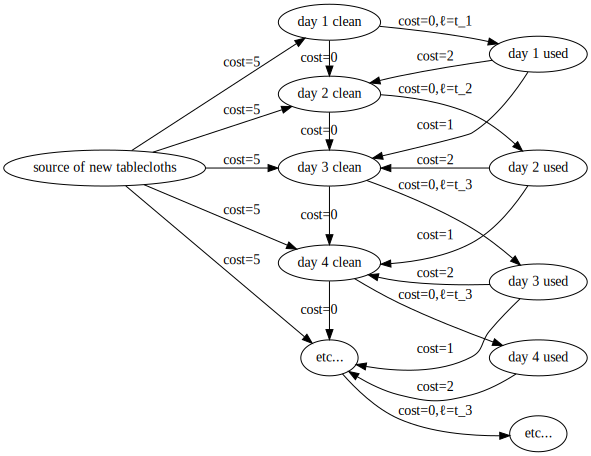

In [71]:
from graphviz import Digraph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

dot = Digraph('tablecloth network model')

dot.attr(rankdir='LR')
dot.node('s','source of new tablecloths')

with dot.subgraph(name='clean') as c:
    c.attr(rank='same')
    c.node('d1c','day 1 clean')
    c.node('d2c','day 2 clean')
    c.node('d3c','day 3 clean')
    c.node('d4c','day 4 clean')
    c.node('d5c','etc...')


with dot.subgraph(name='dirty') as c:
    c.attr(rank='same')
    c.node('d1u','day 1 used')
    c.node('d2u','day 2 used')
    c.node('d3u','day 3 used')
    c.node('d4u','day 4 used')
    c.node('d5u','etc...')

    
dot.edge('s','d1c',label='cost=5')
dot.edge('s','d2c',label='cost=5')
dot.edge('s','d3c',label='cost=5')
dot.edge('s','d4c',label='cost=5')
dot.edge('s','d5c',label='cost=5')


dot.edge('d1c','d2c',label='cost=0')
dot.edge('d2c','d3c',label='cost=0')
dot.edge('d3c','d4c',label='cost=0')
dot.edge('d4c','d5c',label='cost=0')


dot.edge('d1c','d1u',label='cost=0,ℓ=t_1')
dot.edge('d2c','d2u',label='cost=0,ℓ=t_2')
dot.edge('d3c','d3u',label='cost=0,ℓ=t_3')
dot.edge('d4c','d4u',label='cost=0,ℓ=t_3')
dot.edge('d5c','d5u',label='cost=0,ℓ=t_3')


dot.edge('d1u','d2c',label='cost=2') ## fast laundry
dot.edge('d2u','d3c',label='cost=2') ## fast laundry
dot.edge('d3u','d4c',label='cost=2') ## fast laundry
dot.edge('d4u','d5c',label='cost=2') ## fast laundry


dot.edge('d1u','d3c',label='cost=1') ## slow laundry
dot.edge('d2u','d4c',label='cost=1') ## slow laundry
dot.edge('d3u','d5c',label='cost=1') ## slow laundry

dot

(extrapolate the diagram for the remaining days...)

---

How do we make a linear program of this??

The above diagram represents a *directed graph*. The edges in this graph -- i.e. the arrows between nodes -- track the "flow" of tablecloths.

- We introduce a variable for each arrow. The value of the variable represents the number of tablecloths that move from the start to finish of the arrow.

- Some arcs have lower bounds (e.g. $\ell$ = t_1). If no lower bound is mentioned, there is an implied lower bound of 0.

- Some arcs have upper bounds.
  These model maximum supply or throughput. Nothing implies a bound of $\infty$.
  
- Each “internal” node has conservation -- i.e. ``outputs - inputs = 0``.

- Each arc has a cost. The Objective function is the sum of the quantities (arc costs $\times$ flow variable).


Since we are to have one variable for each arrow in the above diagram,

- $b_i$ = # tablecloths bought on day $i, 1 ≤ i ≤ 7$.
- $u_i$ = # tablecloths used on day $i, 1 ≤ i ≤ 7$.
- $c_i$ = # tablecloths carried over from day $i$ to $i + 1$ for $0 \le i \le 6$
- $f_i$ = # dirty tablecloths sent to fast laundry on day $i$
- $s_i$ = # dirty tablecloths sent to slow laundry on day $i$
- $t_i$ = # tablecloths needed on day $i$.

Now the objective equation has the form:

$$5\sum_{i=1}^7 b_i + 0 \sum_{i=1}^7 u_i + 0 \sum_{i=1}^6 c_i + 2 \sum_{i=1}^6 f_i + \sum_{i=1}^5 s_i$$

We require $t_i \le u_i$ for $1 \le i \le 7$ (lower bounds). These lower bounds arise from the arrows from "Day i clean" to "Day i used" with the label $\ell = t_i$. 

We impose no upper bounds on the variables.

For each node, we get a conservation equation:

- node "day 1 clean": $u_1 + c_1 − b_1 = 0$
- node "day 1 used":  $s_1 + f_1 − u_1 = 0$ 
- node "day 2 clean": $u_2 + c_2 − b_2 − c_1 − f_1 = 0$
- node "day 2 used":  $s_2 + f_2 − u_2 = 0$
- node "day 3 clean": $u_3 + c_3 − b_3 − c_2 − f_2 − s_1 = 0$
- node "day 3 used":  $s_3 + f_3 − u_3 = 0$
- and so on...

Note for example that 2 arrows leave and 3 arrows arrive at the node "Day 2 clean", while 2 arrows leave and 4 arrows arrive at the node "Day 3 clean". The above equations reflect these counts.


Remarks:
--------
- There are $2 \times 7 + 2 \times 6 + 5 = 31$ variables. So the objective function is given by a vector $\mathbf{c} \in \mathbb{R}^{31} = \mathbb{R}^{1 \times 31}$.

- there are 13 "equality constraints" arising from the conservation equation at each node (note that there is no conservation at the node "day 7 used", since it is a terminal node). Thus the equality constraints are given by a $13 \times 31$ matrix $A$ (they amount to the condition
$A\mathbf{x} = \mathbf{0}$ for $\mathbf{x} \in \mathbb{R}^{31} = \mathbb{R}^{31 \times 1}$).

- there are 7 inequality constraints, given by the condition $B \mathbf{x} \le \mathbf{b}$ for a $7 \times 31$ matrix $B$ and a vector $\mathbf{b} \in \mathbb{R}^7 = \mathbb{R}^{7 \times 1}$.





Implementation (sketch)
-----------------------

The main task in solving this model via ``python`` is producing the matrices $A$ and $B$.

For example, the conservation at the node

- node "day 3 clean": $u_3 + c_3 − b_3 − c_2 − f_2 − s_1 = 0$

results in a *row* of the matrix $A$.

Let's order the variables as follows: 
$$b_1,b_2,\dots,b_7,u_1,\dots,u_7,c_1,\dots,c_7,f_1,\dots,f_7,s_1,\dots,s_7,t_1,\dots,t_7$$

With this order, the "day 3 clean" node leads to the following column of $A$:

$$\begin{bmatrix}
    \mathbf{bb} & \mathbf{uu} & \mathbf{cc} & \mathbf{ff} & \mathbf{ss} & \mathbf{tt} \\
  \end{bmatrix}$$

where $\mathbf{bb},\mathbf{uu},\mathbf{cc},\mathbf{ff},\mathbf{ss},\mathbf{tt} \in \mathbb{R}^{1 \times 7}$
and we have

$$\mathbf{bb} = \begin{bmatrix}
0 & 0 & -1 & 0 & 0 & 0 & 0
\end{bmatrix} = -\mathbf{e}_3, \quad \mathbf{uu} = \begin{bmatrix}
0 & 0 & 1 & 0 & 0 & 0 & 0 
\end{bmatrix} = \mathbf{e}_3,
$$
$$\mathbf{cc} = -\mathbf{e}_2, \mathbf{ff} = \mathbf{e}_2,\mathbf{ss} = \mathbf{e}_1,\mathbf{tt} =\mathbf{0}$$

In [9]:
import numpy as np

def sbv(index,length):
    return np.array([1.0 if i == index-1 else 0.0 for i in range(length)])

## produce the row corresponding to the "day 3 clean" node.
##
row = np.block([(-1)*sbv(3,7), ## bb
                 sbv(3,7),       ## uu
                 (-1)*sbv(2,7),  ## cc
                 sbv(2,7),       ## ff
                 sbv(1,7),       ## ss
                 np.zeros(7) ## tt
               ])


## Note that if you had constructed the following rows -- row1, row2, row3, ..., row7 -- you'd produce the matrix A via
## A = np.array([row1,row2,row3,...,row7])

print(row)

[-0. -0. -1. -0. -0. -0. -0.  0.  0.  1.  0.  0.  0.  0. -0. -1. -0. -0.
 -0. -0. -0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]


----
The idea is that "network flow" graphs are a tool to help formulate the linear program. Let's look 


Grocery example
===============

Let's look at another example.

A fruit wholesaler buys and sells apples according to the following prices and demand:

| Month                 | Aug  | Sep | Oct | Nov | Dec | Jan | Feb | Mar | Apr | May | Jun | Jul |
|:-----                 | --:  | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: | --: |
| price/kg  from grower | 0.80 | 0.55| 0.55| 0.65| 0.75| 0.85| 0.95| -   | -   | -   | -   | -   |
| sale price/kg         | 0.90 | 0.65| 0.65| 0.85| 1.00| 1.00| 1.20| 1.20| 1.20| 1.00| 0.80| 0.80|
| deman in 1000kg       | 10   | 15  | 15  | 15  | 13  | 10  | 10  | 10  | 9   | 7   | 5   | 5   |

The wholesaler can store 50,000kg at a cost of \$0.025 per kg per month. Unlimited supplies are available from September to January but only 15,000kg are available in August and February and none during the rest of the year. 

Maximize the profit!

We'll begin by formulating the flow model.

Remember that each edge in the graph corresponds to a variable in our linear program, and we'll indicate the cost, the upper bound, and the lower bound as $[c,u,\ell]$

Let's make a partial diagram:

In [2]:
from graphviz import Digraph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

dot = Digraph('fruit wholesaler model')

dot.attr(rankdir='LR')
dot.node('g','grower')

with dot.subgraph(name='months') as c:
    c.attr(rank='same')
    c.node('aug')
    c.node('sep')
    c.node('oct')
    c.node('nov')
    c.node('feb')
    c.node('mar')

    
dot.node('d','demand')

dot.edge('g','aug',label='[-.8,15000,0]')
dot.edge('g','sep',label='[-.55,∞,0]')
dot.edge('g','oct',label='[-.55,∞,0]')
dot.edge('g','nov',label='[-.65,∞,0]')
dot.edge('g','feb',label='[-.95,15000,0]')

dot.edge('aug','sep',label='[-0.025,50K,0]')
dot.edge('sep','oct',label='[-0.025,50K,0]')
dot.edge('oct','nov',label='[-0.025,50K,0]')
dot.edge('feb','mar',label='[-0.025,50K,0]')


dot.edge('aug','d',label='[0.9,10000,10000]')
dot.edge('sep','d',label='[0.65,15000,15000]')
dot.edge('oct','d',label='[0.65,15000,15000]')
dot.edge('nov','d',label='[0.85,15000,15000]')
dot.edge('feb','d',label='[1.20,10000,10000]')
dot.edge('mar','d',label='[1.20,10000,10000]')

    
dot

dot.format='png'
dot.render()

'fruit wholesaler model.gv.png'

Now let's formulate the linear program.

We'll order the months as ``Jan`` = 1, ``Feb`` = 2, etc.

We need to name our variables:
- $g_i$ = # kg bought in month $i$, $1 \le i \le 12$.
- $s_i$ = # kg stored from month $i$ to $i+1$.
- $d_i$ = # kg sold in month $i$

Lower bounds:
- $10000 \le d_8$
- $10000 \le d_9$
- $\vdots$

Upper bounds:
- $g_8 \le 15000$
- $g_2 \le 15000$
- $s_i \le 50000$
- $d_8 \le 10000$
- $d_9 \le 15000$
- $\vdots$

Conservation:
- $s_8 + d_8 - g_8 = 0$
- $s_9 + d_9 - g_9 - s_8 = 0$.
- $\vdots$
- $s_2 + d_2 - g_2 - s_1 = 0$.
- $s_3 + d_3 - s_2 = 0$
- $\vdots$

Objective -- maximize:
$$\begin{matrix}
  -0.80g_8 - 0.025s_8 + 0.9d_8 + \\ 
  -0.55g_9 - 0.025s_9 + 0.65d_9  + \\
  \dots \\
  \end{matrix}$$
  
